In [1]:
%matplotlib widget

import copy
import json
import numpy as np
import requests

from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from os import environ, path

ModuleNotFoundError: No module named 'ipympl'

In [2]:
out_dir = path.join(environ.get("HOME"), "Chaos", "DL")
out_file_name = "cov19"

In [3]:
euro = {"at": "Austria", "be": "Belgium", "ba": "Bosnia and Herzegovina", "bg": "Bulgaria",
        "hr": "Croatia", "cy": "Cyprus", "cz": "Czechia", "dk": "Denmark", "ee": "Estonia",
        "fi": "Finland", "fr": "France", "de": "Germany", "gr": "Greece", "hu": "Hungary",
        "ie": "Ireland", "it": "Italy", "lv": "Latvia", "li": "Liechtenstein",
        "lt": "Lithuania", "lu": "Luxembourg", "nl": "Netherlands", "no": "Norway",
        "pl": "Poland", "pt": "Portugal", "ro": "Romania", "rs": "Serbia", "sk": "Slovakia",
        "si": "Slovenia", "es": "Spain", "se": "Sweden", "ch": "Switzerland",
        "gb": "United Kingdom"}

In [4]:
regions = {"amro": ["us"],
           "euro": euro.keys()}

In [5]:
population = {"at": 8901000, "be": 11431000, "ba": 3531000, "bg": 6951000,
        "hr": 4190000, "cy": 1189000, "cz": 10637000, "dk": 5822000, "ee": 1323000,
        "fi": 5517000, "fr": 66993000, "de": 83166000, "gr": 10277000, "hu": 9773000,
        "ie": 4761000, "it": 60260000, "lv": 1934000, "li": 38000,
        "lt": 2794000, "lu": 626000, "nl": 17290000, "no": 5367000,
        "pl": 38386000, "pt": 10600000, "ro": 20121000, "rs": 7057000, "sk": 5450000,
        "si": 2064000, "es": 47100000, "se": 10327000, "ch": 8601000,
        "gb": 66435000, "us": 328000000}

In [6]:
cases_day_description = {"key": ["unix_timestamp"],
                         "values": ["cases_per_day_confirmed", "cases_cumulative",
                                    "cases_cumulative_percent_population",
                                    "deaths_per_day_confirmed", "deaths_cumulative",
                                    "deaths_cumulative_permil_population"]}
full_data = {"cases_per_day_data_description": cases_day_description,
             "countries": {}}


In [7]:
# data dimensions; (1) timestamp, (2), region, (3) deaths, (4) cumulative deaths,
# (5) deaths last 7 days, (6) Deaths Last 7 Days Change, (7) Deaths Per Million, (8) Confirmed,
# (9) Cumulative confirmed, (10) Cases Last 7 Days, (11) Cases Last 7 Days Change,
# (12) Cases Per Million
furl = "https://covid19.who.int/page-data/region/%s/country/%s/page-data.json"


In [8]:
# Fetch and convert data from all regions of interest
for reg in regions:
    for country_id in regions[reg]:
        country_name = "United States"
        region = "america"
        if country_id != "us":
            country_name = euro[country_id]
            region = "euro"

        curr_url = furl % (reg, country_id)
        res = requests.get(curr_url)
        print("Fetching country: '%s/%s' at \n\t%s" % (country_id, country_name, curr_url))
        data = json.loads(res.text)

        # Reduce to "timestamp: [confirmed, confirmed_cumulative,
        #                        case_cumulative_percent_population,
        #                        deaths, deaths_cumulative, death_cumulative_permil_population]"
        curr_country = {}
        curr_data = data["result"]["pageContext"]["countryGroup"]["data"]["rows"]
        curr_perc_pop = population[country_id]/100
        curr_perm_pop = population[country_id]/1000
        for i in curr_data:
            case_perc_pop = round(i[8]/curr_perc_pop, 3)
            death_perm_pop = round(i[3]/curr_perm_pop, 3)

            curr_country[i[0]] = [i[7], i[8], case_perc_pop, i[2], i[3], death_perm_pop]

        print("\tLatest cases: %s" % curr_country[list(curr_country.keys())[-1]])
        full_data["countries"][country_id] = {"country_name": country_name,
                                              "region": region,
                                              "population": population[country_id],
                                              "cases": curr_country}


Fetching country: 'us/United States' at 
	https://covid19.who.int/page-data/region/amro/country/us/page-data.json
	Latest cases: [80379, 9032465, 2.754, 813, 228998, 0.698]
Fetching country: 'at/Austria' at 
	https://covid19.who.int/page-data/region/euro/country/at/page-data.json
	Latest cases: [4526, 111110, 1.248, 17, 1114, 0.125]
Fetching country: 'be/Belgium' at 
	https://covid19.who.int/page-data/region/euro/country/be/page-data.json
	Latest cases: [12, 440923, 3.857, 20, 11737, 1.027]
Fetching country: 'ba/Bosnia and Herzegovina' at 
	https://covid19.who.int/page-data/region/euro/country/ba/page-data.json
	Latest cases: [1415, 51505, 1.459, 14, 1248, 0.353]
Fetching country: 'bg/Bulgaria' at 
	https://covid19.who.int/page-data/region/euro/country/bg/page-data.json
	Latest cases: [1225, 54069, 0.778, 19, 1298, 0.187]
Fetching country: 'hr/Croatia' at 
	https://covid19.who.int/page-data/region/euro/country/hr/page-data.json
	Latest cases: [2179, 51495, 1.229, 16, 562, 0.134]
Fetchi

In [9]:
# Save data structure to json file
fn = path.join(out_dir, ("%s.json" % out_file_name))
print("\nWriting to file %s" % fn)
with open(fn, "w") as fp:
    json.dump(full_data, fp)



Writing to file /home/sommer/Chaos/DL/cov19.json


In [10]:
# congregate data; get euro sum
euro_cases = {"country_name": "EU",
              "population": 0,
              "cases_total": [],
              "cases": {}}

for i in full_data["countries"]:
    if i != "us":
        euro_cases["population"] = euro_cases["population"] + full_data["countries"][i]["population"]
        curr_cases = copy.deepcopy(full_data["countries"][i]["cases"])

        # Congregate latest total euro cases
        if not euro_cases["cases_total"]:
            euro_cases["cases_total"] = curr_cases[list(curr_cases.keys())[-1]]
        else:
            curr_list = curr_cases[list(curr_cases.keys())[-1]]
            euro_cases["cases_total"] = [sum(x) for x in zip(euro_cases["cases_total"], curr_list)]

        # Congregate daily total euro cases
        if not euro_cases["cases"]:
            euro_cases["cases"] = curr_cases
        else:
            for j in curr_cases:
                euro_cases["cases"][j] = [sum(x) for x in zip(euro_cases["cases"][j], curr_cases[j])]

# Fix euro percentages
curr_perc_pop = euro_cases["population"] / 100
curr_perm_pop = euro_cases["population"] / 1000

# Euro percentage cases total
euro_cases["cases_total"][2] = round(euro_cases["cases_total"][1] / curr_perc_pop, 3)
euro_cases["cases_total"][5] = round(euro_cases["cases_total"][4] / curr_perm_pop, 3)

# Euro percentages per day
for i in euro_cases["cases"]:
    euro_cases["cases"][i][2] = round(euro_cases["cases"][i][1] / curr_perc_pop, 3)
    euro_cases["cases"][i][5] = round(euro_cases["cases"][i][4] / curr_perm_pop, 3)


In [11]:
# Basic plots - prepare data
# europe data as example

cases_dates = []
confirmed = []
confirmed_cumulative = []
case_cumulative_percent_population = []
deaths = []
deaths_cumulative = []
death_cumulative_permil_population = []

for i in euro_cases["cases"]:
    cases_dates.append(datetime.fromtimestamp(i/1000))
    confirmed.append(euro_cases["cases"][i][0])
    confirmed_cumulative.append(euro_cases["cases"][i][1])
    case_cumulative_percent_population.append(euro_cases["cases"][i][2])
    deaths.append(euro_cases["cases"][i][3])
    death_cumulative_permil_population.append(euro_cases["cases"][i][4])
    death_cumulative_permil_population.append(euro_cases["cases"][i][5])

In [12]:
# dirty fix to compare euro to us (us sometimes is a day ahead in terms of numbers.)
last_euro_date = cases_dates[-1]

us_cases = full_data["countries"]["us"]["cases"]

uscases_dates = []
usconfirmed = []
usconfirmed_cumulative = []
uscase_cumulative_percent_population = []
usdeaths = []
usdeaths_cumulative = []
usdeath_cumulative_permil_population = []

for i in us_cases:
    usconfirmed.append(us_cases[i][0])
    usconfirmed_cumulative.append(us_cases[i][1])
    uscase_cumulative_percent_population.append(us_cases[i][2])
    usdeaths.append(us_cases[i][3])
    usdeath_cumulative_permil_population.append(us_cases[i][4])
    usdeath_cumulative_permil_population.append(us_cases[i][5])
    if last_euro_date == datetime.fromtimestamp(i/1000):
        break


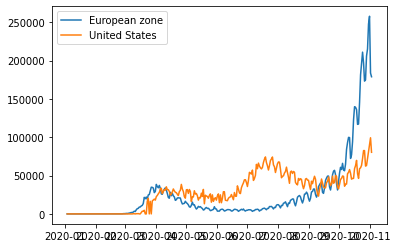

In [18]:
title = "Per day Covid19 cases"
x_label = "Date"

plt.clf()
plt.plot(cases_dates, confirmed, label="European zone")
plt.plot(cases_dates, usconfirmed, label="United States")
plt.title = title
plt.xlabel = x_label
plt.legend()
plt.show()


In [ ]:
markers_available = list(Line2D.markers.keys())
marker_idx = -1
for j in full_data["countries"]:
    if full_data["countries"][j]["region"] == "america":
        continue

    country = full_data["countries"][j]["country_name"]
    print("Working on %s" % country)

    curr_confirmed = []
    curr_data = full_data["countries"][j]["cases"]
    for i in curr_data:
        curr_confirmed.append(curr_data[i][0])

    # Handle individual markers
    marker_idx = marker_idx + 1
    plt.plot(cases_dates, curr_confirmed, label=country, marker=markers_available[marker_idx])

plt.title = "Per day cases euro countries"
plt.xlabel = "Date"
plt.legend()
plt.show()


In [ ]:
# plot last 30 days euro zone
curr_len = len(cases_dates)
marker_idx = -1
for j in full_data["countries"]:
    if full_data["countries"][j]["region"] == "america":
        continue

    country = full_data["countries"][j]["country_name"]
    print("Working on %s" % country)

    curr_confirmed = []
    curr_data = full_data["countries"][j]["cases"]
    for i in curr_data:
        curr_confirmed.append(curr_data[i][0])

    # Handle individual markers
    marker_idx = marker_idx + 1
    plt.plot(cases_dates[curr_len-30:curr_len-1], curr_confirmed[curr_len-30:curr_len-1],
             label=country, marker=markers_available[marker_idx])

plt.title = "Per day cases euro countries; last 30 days"
plt.xlabel = "Date"
plt.legend()
plt.show()


In [ ]:
# display current numpy printoptions
print(np.get_printoptions())

# set precision to 3
np.set_printoptions(precision=3)


In [ ]:
use_date = list(euro_cases["cases"].keys())[-1]
curr_cases = copy.deepcopy(full_data["countries"])

euro_stat = euro_cases["cases"][use_date]
us_stat = curr_cases["us"]["cases"][use_date]
names = ["Europe", "United states"]

aggregated = list()
aggregated.append(euro_stat)
aggregated.append(us_stat)

for i in curr_cases:
    if curr_cases[i]["region"] == "america":
        continue
    country = curr_cases[i]["country_name"]
    print("Working on %s" % country)

    names.append(country)
    aggregated.append(curr_cases[i]["cases"][use_date])

labels = ["cases", "cumulative", "[%] population", "deaths", "cumulative", "[‰] population"]


In [ ]:

# format large numbers with comma as 1000 separator
format_aggregated = copy.deepcopy(aggregated)
for line_idx in range(len(format_aggregated)):
    for val_idx in range(len(format_aggregated[line_idx])):
        curr_val = format_aggregated[line_idx][val_idx]
        format_aggregated[line_idx][val_idx] = f'{curr_val:,}'

_, ax = plt.subplots()

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Hide figure border
for spine_location in ax.spines:
    ax.spines[spine_location].set_visible(False)

column_labels = labels
row_labels = names
tbl = ax.table(cellText=format_aggregated, rowLabels=row_labels,
               colLabels=column_labels, loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(range(len(labels)))

plt.title = "Dashboard"
plt.tight_layout()
plt.show()
